In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,5]
plt.rcParams['text.usetex'] = True
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

from skimage.data import shepp_logan_phantom
import astra



In [2]:
image = shepp_logan_phantom()
image.shape

(400, 400)

In [3]:
vol_geom = astra.create_vol_geom(400, 400)
proj_geom = astra.create_proj_geom('parallel', 1.0, 384, np.linspace(0,np.pi,1000,False))


P = image
proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
sinogram_id, sinogram = astra.create_sino(P, proj_id)



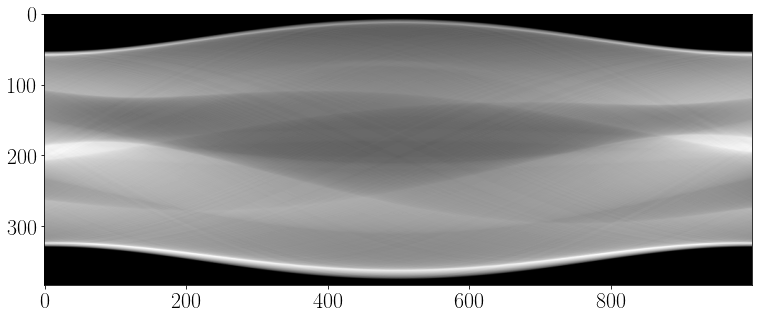

In [4]:
plt.imshow(sinogram.T, cmap="gray")
plt.savefig("SIRT_sinogram.png")


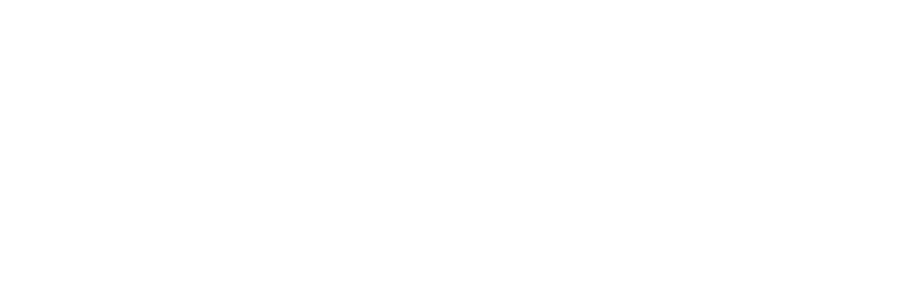

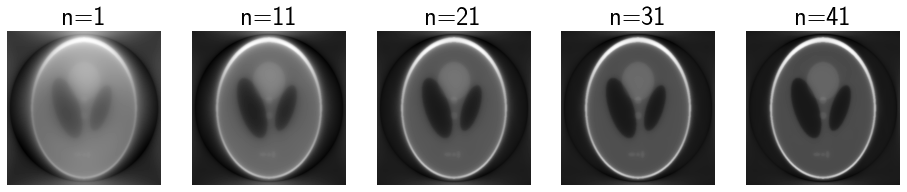

In [5]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('SIRT_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 1500 iterations of the algorithm one at a time, keeping track of errors
nIters = 1500
phantom_error = np.zeros(nIters)
residual_error = np.zeros(nIters)

plt.axis("off")
fig, ax = plt.subplots(1,5)
for i in range(nIters):
    # Run a single iteration
    astra.algorithm.run(alg_id, 1)
    residual_error[i] = astra.algorithm.get_res_norm(alg_id)
    rec = astra.data2d.get(rec_id)
    if i % 10 == 0 and i//10 < 5:
        ax[i//10].set_axis_off()
        ax[i//10].imshow(rec.reshape((400,400)), cmap="gray")
        ax[i//10].set_title(f"n={i+1}")
    phantom_error[i] = np.sqrt(((rec - P)**2).sum())

plt.savefig("SIRT_iterations.png")


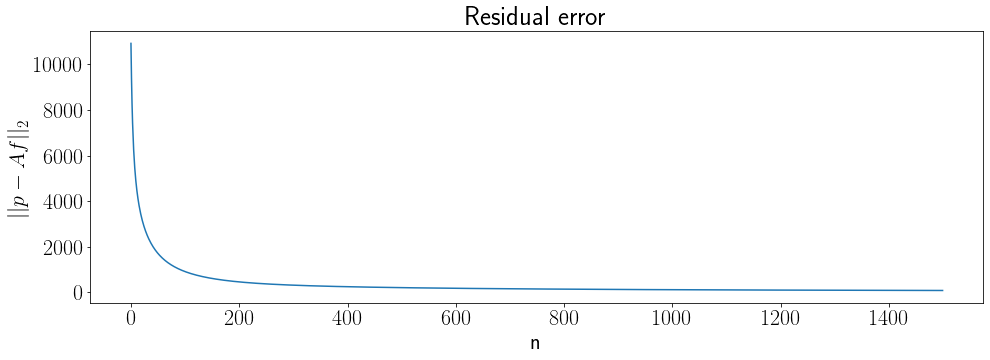

In [6]:
plt.plot(residual_error)
plt.title("Residual error")
plt.xlabel("n")
plt.ylabel(r"$||p-Af||_2$")
plt.savefig("SIRT_residual.png")

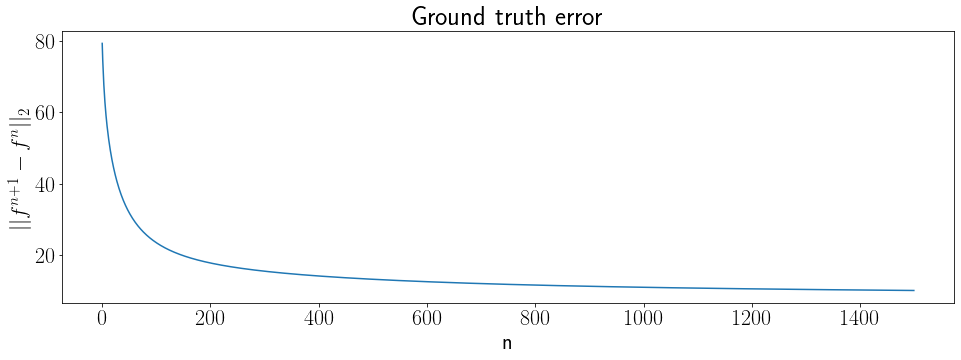

In [7]:
plt.plot(phantom_error)
plt.title("Ground truth error")
plt.xlabel("n")
plt.ylabel(r"$||f^{n+1}-f^{n}||_2$")
plt.savefig("SIRT_gtres.png")

In [8]:
W = astra.OpTomo(proj_id)

In [9]:
bp = W.T*sinogram

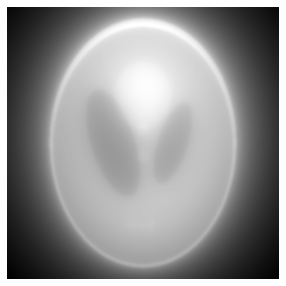

In [10]:
plt.imshow(bp.reshape(400,400), cmap="gray")
plt.axis("off")
plt.savefig("backprojection.png")

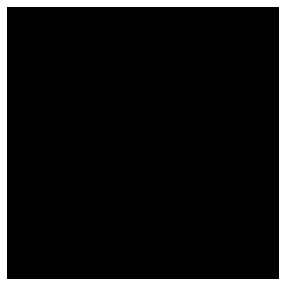

In [11]:
plt.imshow(np.zeros((400,400)), cmap="gray")
plt.axis("off")
plt.savefig("zero.png")